In [6]:
# implement https://arxiv.org/pdf/1705.08690.pdf on avalanche framework on permuted MNIST
# https://aahaanmaini.medium.com/mimicking-human-continual-learning-in-a-neural-network-c15e1ae11d70
#continual learning

## create GAN

In [1]:
from helper_func import generate_images, train_GAN

c:\Users\mathi\Anaconda3\envs\DL2\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\mathi\Anaconda3\envs\DL2\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")


In [2]:
#https://github.com/znxlwm/pytorch-MNIST-CelebA-GAN-DCGAN/blob/master/pytorch_MNIST_GAN.py
import matplotlib.pyplot as plt
from torch import nn
import itertools
import pickle
#import imageio
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

# G(z)
class generator(nn.Module):
    # initializers
    def __init__(self, input_size=32, n_class = 10):
        super(generator, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.fc2 = nn.Linear(self.fc1.out_features, 512)
        self.fc3 = nn.Linear(self.fc2.out_features, 1024)
        self.fc4 = nn.Linear(self.fc3.out_features, n_class)

    # forward method
    def forward(self, input):
        x = F.leaky_relu(self.fc1(input), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = F.tanh(self.fc4(x))

        return x

class discriminator(nn.Module):
    # initializers
    def __init__(self, input_size=32, n_class=10):
        super(discriminator, self).__init__()
        self.fc1 = nn.Linear(input_size, 1024)
        self.fc2 = nn.Linear(self.fc1.out_features, 512)
        self.fc3 = nn.Linear(self.fc2.out_features, 256)
        self.fc4 = nn.Linear(self.fc3.out_features, n_class)

    # forward method
    def forward(self, input):
        x = F.leaky_relu(self.fc1(input), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.sigmoid(self.fc4(x))

        return x

fixed_z_ = torch.randn((5 * 5, 100))    # fixed noise
fixed_z_ = Variable(fixed_z_, volatile=True)

# training parameters
batch_size = 128
lr = 0.0002

# data_loader
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])
# network
G = generator(input_size=100, n_class=28*28)
D = discriminator(input_size=28*28, n_class=1)

# Binary Cross Entropy loss
BCE_loss = nn.BCELoss()

# Adam optimizer
G_optimizer = optim.Adam(G.parameters(), lr=lr)
D_optimizer = optim.Adam(D.parameters(), lr=lr)


c:\Users\mathi\Anaconda3\envs\DL2\lib\site-packages\ipykernel_launcher.py:55: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


## naive and scholar

In [3]:
from torch.optim import SGD
from torch.nn import CrossEntropyLoss
from avalanche.training.supervised import Naive
from avalanche.training.plugins import EvaluationPlugin
from avalanche.evaluation.metrics import accuracy_metrics
from avalanche.models import SimpleMLP

#Naive approach
model_naive = SimpleMLP(num_classes=10, hidden_size = 400, hidden_layers=2)

#Continual Learning approach
model_cl_scholar = SimpleMLP(num_classes=10, hidden_size = 400, hidden_layers=2)

optimizer = SGD(model_naive.parameters(), lr=0.001, momentum=0.9)
criterion = CrossEntropyLoss()

########################################################################################
# Continual learning strategy
cl_strategy_naive = Naive(
    model_naive, optimizer, criterion, train_mb_size=32, train_epochs=2, 
    eval_mb_size=32)

# model_cl_scholar strategy
cl_strategy_scholar = Naive(
    model_cl_scholar, optimizer, criterion, train_mb_size=32, train_epochs=2,
    eval_mb_size=32)

## Dataset

In [4]:
from avalanche.benchmarks.classic import SplitMNIST
from avalanche.models import SimpleMLP

transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])
# create transform to grayscale
transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
])
# CL Benchmark Creation
BM = SplitMNIST(n_experiences=5, seed=12345, train_transform=transform, eval_transform=transform)


## Train

### naive

In [5]:
from tqdm import tqdm
import numpy as np
naive_evaluations = []
for experience in BM.train_stream:
    print('training experience', experience.current_experience)
    print('training classes', experience.classes_in_this_experience)
    ############################################################################################################
    # Naive training
    ############################################################################################################
    #train naive model
    cl_strategy_naive.train(experience, verbose=0)
    #test naive model on test stream
    naive_evaluation = cl_strategy_naive.eval(BM.test_stream)
    naive_evaluations.append(naive_evaluation)
    
np.save('evaluations/naive_evaluations.npy', naive_evaluations)


training experience 0
training classes [0, 7]
-- >> Start of training phase << --
100%|██████████| 381/381 [00:08<00:00, 46.99it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.5255
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.8956
100%|██████████| 381/381 [00:09<00:00, 40.19it/s]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0484
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9871
-- >> End of training phase << --
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 63/63 [00:01<00:00, 61.09it/s]
> Eval on experience 0 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp000 = 0.0220
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.9945
-- Starting eval on experience 1 (Task 0) from test stream --
100%|██████████| 66/66 [00:01<00:00, 54.87it/s]
> Eval on experience 1 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp001 

### scholar with GAN

In [11]:
from avalanche.benchmarks.utils import AvalancheConcatDataset
from avalanche.benchmarks.utils import AvalancheDataset
from avalanche.training.templates import SupervisedTemplate


class Cumulative(SupervisedTemplate):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.dataset = None  # cumulative dataset

    def train_dataset_adaptation(self, **kwargs):
        super().train_dataset_adaptation(**kwargs)
        curr_data = self.experience.dataset
        if self.dataset is None:
            self.dataset = curr_data
        else:
            G.eval()
            D.eval()
            generated_images = torch.zeros((len(experience), 28*28))
            generated_labels = torch.zeros((len(experience)))
            for i in range(len(experience.dataset)):
                fixed_z_ = torch.randn((5 * 5, 100))    # fixed noise
                test_images = G(fixed_z_)
                test_images = test_images.view(test_images.size(0), 1, 28, 28)
                test_images = test_images.data
                generated_images[i] = test_images[0].view(28*28)
                generated_labels[i] = experience.current_experience
            generated_dataset = AvalancheDataset(generated_images, generated_labels)
            self.dataset = AvalancheConcatDataset([self.dataset, generated_dataset])
            #train new GAN
            train_loader = torch.utils.data.DataLoader(self.dataset, batch_size=batch_size, shuffle=True)
            G, D, D_losses, G_losses = train_GAN(G, D, train_loader, G_optimizer, D_optimizer, train_epoch = 2)
            generate_images(G, 25)
            
        self.adapted_dataset = self.dataset.train()

strategy = Cumulative(model=cl_strategy_scholar, optimizer=optimizer, criterion=criterion, train_mb_size=128)

train_hist = {}
train_hist['D_losses'] = []
train_hist['G_losses'] = []
for experience in BM.train_stream:
    print('training experience', experience.current_experience)
    print('training classes', experience.classes_in_this_experience)
    strategy.train(experience, verbose=0)

training experience 0
training classes [0, 7]


TypeError: train() missing 1 required positional argument: 'experiences'

training experience 0
training classes [0, 7]


100%|██████████| 96/96 [00:15<00:00,  6.26it/s]


[1/2]:GAN loss_d: 1.190, loss_g: 0.853


100%|██████████| 96/96 [00:15<00:00,  6.25it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[2/2]:GAN loss_d: 1.113, loss_g: 1.178


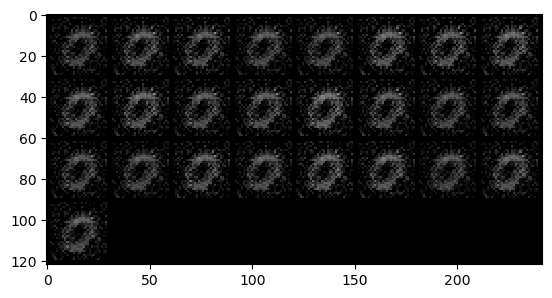

-- >> Start of training phase << --


AttributeError: 'AvalancheDataset' object has no attribute 'dataset'

In [7]:
from torch.utils.data import DataLoader
from avalanche.benchmarks.utils import AvalancheDataset
from avalanche.benchmarks.utils import AvalancheConcatDataset
from tqdm import tqdm
train_hist = {}
train_hist['D_losses'] = []
train_hist['G_losses'] = []
for experience in BM.train_stream:
    print('training experience', experience.current_experience)
    print('training classes', experience.classes_in_this_experience)
    ############################################################################################################
    # Dataset manipulation
    ############################################################################################################
    train_loader = DataLoader(experience.dataset, batch_size=batch_size, shuffle=True)
    combined_data = experience.dataset
    if experience.current_experience != 0:
        G.eval()
        D.eval()
        generated_images = torch.zeros((len(experience), 28*28))
        generated_labels = torch.zeros((len(experience)))
        for i in range(len(experience.dataset)):
            fixed_z_ = torch.randn((5 * 5, 100))    # fixed noise
            test_images = G(fixed_z_)
            test_images = test_images.view(test_images.size(0), 1, 28, 28)
            test_images = test_images.data
            generated_images[i] = test_images[0].view(28*28)
            generated_labels[i] = experience.current_experience
        generated_dataset = AvalancheDataset(generated_images, generated_labels)
        combined_data = AvalancheConcatDataset([combined_data, generated_dataset])
        train_loader = DataLoader(combined_data, batch_size=batch_size, shuffle=True)

    ############################################################################################################
    # GAN training
    ############################################################################################################
    G, D, D_losses, G_losses = train_GAN(G, D, train_loader, G_optimizer, D_optimizer, train_epoch = 2)
    generate_images(G, 25)
    train_hist['D_losses'].append(torch.mean(torch.FloatTensor(D_losses)))
    train_hist['G_losses'].append(torch.mean(torch.FloatTensor(G_losses)))

    ############################################################################################################
    # CL training
    ############################################################################################################
    #train cl model
    #TODO FIX COMBINED DATA
    # probably have to create an experience for the new dataset!?!? (I hate avalanche)
    avalanche_train_dataset = AvalancheDataset(combined_data)
    cl_strategy_scholar.train(avalanche_train_dataset, verbose=0)
    scholar_evaluation = cl_strategy_scholar.eval(BM.test_stream)


## plots

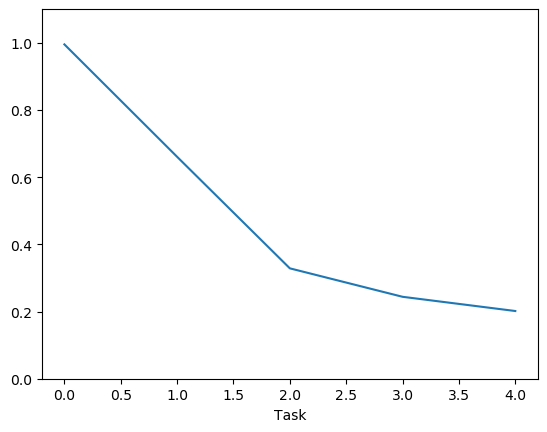

In [70]:
#TODO: use naive and scholar evaluation to plot results
from helper_func import get_accuracies
naive_evaluations = np.load('evaluations/naive_evaluations.npy', allow_pickle=True)
#scholar_evaluations = np.load('evaluations/scholar_evaluations.npy', allow_pickle=True)

naive_accuracies = get_accuracies(naive_evaluations)
#cl_accuracies = get_accuracies(scholar_evaluation)

plt.plot(naive_accuracies)
#plt.plot(cl_accuracies)

plt.xlabel('Task')

plt.ylim(0, 1.1)
plt.show()